In [3]:
%matplotlib inline
import pandas as pd
import numpy as np

## 2014 Ebola Outbreak Data

[Caitlin Rivers' `ebola` GitHub repository](https://github.com/cmrivers/ebola) contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. These data are licenced for both commercial and non-commercial use. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

![ebola](images/ebola.jpg)

From these data files, we will use pandas to import them and create a single data frame that includes the **daily totals of new cases** for each country. 

In [1]:
url_base = 'https://raw.githubusercontent.com/cmrivers/ebola/master/guinea_data/'

In [6]:
pd.read_csv(url_base+'2014-09-02.csv').head()

,Date,Description,Totals,Conakry,Gueckedou,Macenta,Dabola,Kissidougou,Dinguiraye,Telimele,...,Mzerekore,Yomou,Dubreka,Forecariah,Kerouane,Coyah,Dalaba,Beyla,Kindia,Lola
0,2014-09-02,New cases of suspects,11,NaN,5,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-02,New cases of probables,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-02,New cases of confirmed,14,NaN,4,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-02,Total new cases registered so far,25,0,9,12,0,0,0,0,...,0,0,1,0,0,3,NaN,NaN,NaN,NaN
4,2014-09-02,Total cases of suspects,49,15,5,17,0,0,0,0,...,0,1,1,2,5,0,NaN,NaN,NaN,NaN


Clearly, we will need to develop row **masks** to extract the data we need across all files, without having to manually extract data from each file.

Let's hack at one file to develop the mask.

In [18]:
sample = pd.read_csv(url_base+'2014-09-02.csv')

To prevent issues with capitalization, we will simply revert all labels to lower case.

In [10]:
lower_vars = sample.Description.str.lower()

Since we are interested in extracting new cases only, we can use the **string accessor** attribute to look for key words that we would like to include or exclude.

In [11]:
case_mask = (lower_vars.str.contains('new') 
             & (lower_vars.str.contains('case') | lower_vars.str.contains('suspect')) 
             & ~lower_vars.str.contains('non')
             & ~lower_vars.str.contains('total'))

We could have instead used regular expressions to do the same thing.

Finally, we are only interested in three columns.

In [14]:
sample.loc[case_mask, ['Date', 'Description', 'Totals']]

,Date,Description,Totals
0,2014-09-02,New cases of suspects,11
1,2014-09-02,New cases of probables,0
2,2014-09-02,New cases of confirmed,14
15,2014-09-02,New cases of confirmed among health workers,0


We can now embed this operation in a loop over all the filenames in the database. We first need to create a range of dates, since the data files are organized by date.

In [27]:
foo = outbreak_dates[0]

In [33]:
str(foo).split(' ')[0]

'2014-07-01'

In [34]:
outbreak_dates = [str(date).split(' ')[0] for date in pd.date_range('2014-07-01', '2014-11-30')]

In [38]:
datasets = []
for country in ('guinea', 'sl', 'liberia'):
    
    print('Getting {} data files'.format(country))
    for date in outbreak_dates:
        
        file = 'https://raw.githubusercontent.com/cmrivers/ebola/master/{}_data/{}.csv'.format(country, date)
        try:
            data = pd.read_csv(file)
            print('\t{}'.format(date))
        except Exception:
            continue
        
        # Convert to lower case to avoid capitalization issues
        data.columns = data.columns.str.lower()
        # Column naming is inconsistent. These procedures deal with that.
        keep_columns = ['date']
        if 'description' in data.columns:
            keep_columns.append('description')
        else:
            keep_columns.append('variable')
            
        if 'totals' in data.columns:
            keep_columns.append('totals')
        else:
            keep_columns.append('national')
            
        # Index out the columns we need, and rename them
        keep_data = data[keep_columns]
        keep_data.columns = 'date', 'variable', 'totals'
        
        # Extract the rows we might want
        lower_vars = keep_data.variable.str.lower()
        # Of course we can also use regex to do this
        case_mask = (lower_vars.str.contains('new') 
                     & (lower_vars.str.contains('case') | lower_vars.str.contains('suspect') 
                                                        | lower_vars.str.contains('confirm')) 
                     & ~lower_vars.str.contains('non')
                     & ~lower_vars.str.contains('total'))
        
        keep_data = keep_data[case_mask].dropna()
        
        # Convert data types
        keep_data['date'] = pd.to_datetime(keep_data.date)
        keep_data['totals'] = keep_data.totals.astype(int)
        
        # Assign country label and append to datasets list
        datasets.append(keep_data.assign(country=country))
        

Getting guinea data files
	2014-08-04
	2014-08-26
	2014-08-27
	2014-08-30
	2014-08-31
	2014-09-02
	2014-09-04
	2014-09-07
	2014-09-08
	2014-09-09
	2014-09-11
	2014-09-14


KeyboardInterrupt: 

Now that we have a list populated with `DataFrame` objects for each day and country, we can call `concat` to concatenate them into a single `DataFrame`.

In [11]:
all_data = pd.concat(datasets)
all_data.head()

,date,variable,totals,country
0,2014-08-04,New cases of suspects,5,guinea
1,2014-08-04,New cases of probables,0,guinea
2,2014-08-04,New cases of confirmed,4,guinea
9,2014-08-04,New deaths registered today (confirmed),2,guinea
11,2014-08-04,New deaths registered today (suspects),0,guinea


This works because the structure of each table was identical

### Manipulating indices

Notice from above, however, that the index contains redundant integer index values. We can confirm this:

In [12]:
all_data.index.is_unique

False

We can create a new unique index by calling the `reset_index` method on the new data frame after we import it, which will generate a new ordered, unique index.

In [13]:
all_data = pd.concat(datasets).reset_index(drop=True)
all_data.head()

,date,variable,totals,country
0,2014-08-04,New cases of suspects,5,guinea
1,2014-08-04,New cases of probables,0,guinea
2,2014-08-04,New cases of confirmed,4,guinea
3,2014-08-04,New deaths registered today (confirmed),2,guinea
4,2014-08-04,New deaths registered today (suspects),0,guinea


**Reindexing** allows users to manipulate the data labels in a DataFrame. It forces a DataFrame to conform to the new index, and optionally, fill in missing data if requested.

A simple use of `reindex` is to alter the order of the rows. For example, records are currently ordered first by country then by day, since this is the order in which they were iterated over and imported. We might arbitrarily want to reverse the order, which is performed by passing the appropriate index values to `reindex`.

In [14]:
all_data.reindex(all_data.index[::-1])

,date,variable,totals,country
636,2014-10-15,new_confirmed,26,sl
635,2014-10-15,new_suspected,52,sl
634,2014-11-07,new_confirmed,45,sl
633,2014-11-07,new_suspected,12,sl
632,2014-11-29,new_confirmed,64,sl
631,2014-11-29,new_suspected,24,sl
630,2014-11-15,new_confirmed,54,sl
629,2014-08-23,new_confirmed,23,sl
628,2014-08-23,new_suspected,4,sl
627,2014-08-19,new_confirmed,9,sl


Notice that the reindexing operation is not performed "in-place"; the original `DataFrame` remains as it was, and the method returns a copy of the `DataFrame` with the new index. This is a common trait for pandas, and is a Good Thing.

We may also wish to reorder the columns this way.

In [15]:
all_data.reindex(columns=['date', 'country', 'variable', 'totals']).head()

,date,country,variable,totals
0,2014-08-04,guinea,New cases of suspects,5
1,2014-08-04,guinea,New cases of probables,0
2,2014-08-04,guinea,New cases of confirmed,4
3,2014-08-04,guinea,New deaths registered today (confirmed),2
4,2014-08-04,guinea,New deaths registered today (suspects),0


## Group by operations

One of pandas' most powerful features is the ability to perform operations on subgroups of a `DataFrame`. These so-called **group by** operations defines subunits of the dataset according to the values of one or more variabes in the `DataFrame`.

For this data, we want to sum the new case counts by day and country; so we pass these two column names to the `groupby` method, then sum the `totals` column accross them.

In [16]:
all_data_grouped = all_data.groupby(['country', 'date'])
daily_cases = all_data_grouped['totals'].sum()
daily_cases.head(10)

country  date      
guinea   2014-08-04    11
         2014-08-26    28
         2014-08-27    22
         2014-08-30    24
         2014-08-31    46
         2014-09-02    25
         2014-09-04    30
         2014-09-07    18
         2014-09-08    18
         2014-09-09    16
Name: totals, dtype: int64

The resulting series retains a hierarchical index from the group by operation. Hence, we can index out the counts for a given country on a particular day by indexing with the appropriate tuple.

In [17]:
daily_cases[('liberia', '2014-09-02')]

liberia                78
2014-09-02 00:00:00    78
Name: totals, dtype: int64

One issue with the data we have extracted is that there appear to be serious **outliers** in the Liberian counts. The values are much too large to be a daily count, even during a serious outbreak.

In [18]:
daily_cases.sort_values(ascending=False)
daily_cases.head(10)

country  date      
guinea   2014-08-04    11
         2014-08-26    28
         2014-08-27    22
         2014-08-30    24
         2014-08-31    46
         2014-09-02    25
         2014-09-04    30
         2014-09-07    18
         2014-09-08    18
         2014-09-09    16
Name: totals, dtype: int64

We can filter these outliers using an appropriate threshold.

In [19]:
daily_cases = daily_cases[daily_cases<200]

## Plotting

pandas data structures have high-level methods for creating a variety of plots, which tends to be easier than generating the corresponding plot using matplotlib. 

For example, we may want to create a plot of the cumulative cases for each of the three countries. The easiest way to do this is to remove the hierarchical index, and create a `DataFrame` of three columns, which will result in three lines when plotted.

First, call `unstack` to remove the hierarichical index:

In [20]:
daily_cases.unstack().head()

date,2014-06-16 00:00:00,2014-06-17 00:00:00,2014-06-22 00:00:00,2014-06-24 00:00:00,2014-06-25 00:00:00,2014-06-28 00:00:00,2014-06-29 00:00:00,2014-07-01 00:00:00,2014-07-02 00:00:00,2014-07-03 00:00:00,...,2014-11-24 00:00:00,2014-11-26 00:00:00,2014-11-27 00:00:00,2014-11-28 00:00:00,2014-11-29 00:00:00,2014-11-30 00:00:00,2014-12-01 00:00:00,2014-12-02 00:00:00,2014-12-04 00:00:00,2014-12-05 00:00:00
country,,,,,,,,,,,,,,,,,,,,,
guinea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liberia,4.0,2.0,14.0,6.0,9.0,10.0,3.0,4.0,4.0,4.0,...,25.0,31.0,46.0,7.0,21.0,11.0,35.0,38.0,NaN,NaN
sl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,115.0,NaN,NaN,110.0,88.0,NaN,86.0,NaN,41.0,78.0


Next, transpose the resulting `DataFrame` to swap the rows and columns.

In [21]:
daily_cases.unstack().T.head()

country,guinea,liberia,sl
date,,,
2014-06-16,NaN,4.0,NaN
2014-06-17,NaN,2.0,NaN
2014-06-22,NaN,14.0,NaN
2014-06-24,NaN,6.0,NaN
2014-06-25,NaN,9.0,NaN


Since we have missing values for some dates, we will assume that the counts for those days were zero (the actual counts for that day may have bee included in the next reporting day's data).

In [22]:
daily_cases.unstack().T.fillna(0).head()

country,guinea,liberia,sl
date,,,
2014-06-16,0.0,4.0,0.0
2014-06-17,0.0,2.0,0.0
2014-06-22,0.0,14.0,0.0
2014-06-24,0.0,6.0,0.0
2014-06-25,0.0,9.0,0.0


Finally, calculate the cumulative sum for all the columns, and generate a line plot, which we get by default.

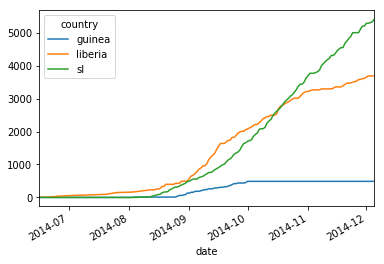

In [23]:
daily_cases.unstack().T.fillna(0).cumsum().plot()

## Resampling

An alternative to filling days without case reports with zeros is to aggregate the data at a coarser time scale. New cases are often reported by week; we can use the `resample` method to summarize the data into weekly values.

In [24]:
weekly_cases = daily_cases.unstack().T.resample('W').sum()
weekly_cases

country,guinea,liberia,sl
date,,,
2014-06-22,NaN,20.0,NaN
2014-06-29,NaN,28.0,NaN
2014-07-06,NaN,12.0,NaN
2014-07-13,NaN,18.0,NaN
2014-07-20,NaN,15.0,NaN
2014-07-27,NaN,56.0,NaN
2014-08-03,NaN,11.0,NaN
2014-08-10,11.0,10.0,NaN
2014-08-17,NaN,106.0,92.0


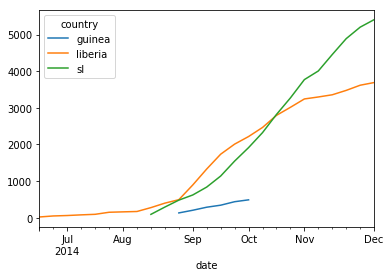

In [25]:
weekly_cases.cumsum().plot()